# CNN - Dogs VS Cats **classification**

**Import TensorFlow**1

# **1** run cells in this order, to train model, and apply model on test set

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras.datasets import mnist
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

Random seed is initialized here, so that reproducibility is ensured

# **2**

In [ ]:
import numpy as np
import tensorflow as tf
import random

seed_value = 10
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f" Random seed = {seed_value}")

 Random seed = 10


Below code is to extract dataset from google drive (adjust code to extract from wherever you need)

# **3**

In [ ]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

#Path to zip file
zip_path = '/content/drive/MyDrive/AIDM/datasets2.zip'

#Extract
if not os.path.exists('/content/datasets'):
    print("Extracting datasets.zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('/content/')
    print("Extraction completed")
else:
    print("Dataset already extracted.Skipping.")

#Verify extraction
print(f"\nDataset folders: {os.listdir('/content/datasets')}")

Mounted at /content/drive
Extracting datasets.zip...
Extraction completed

Dataset folders: ['.DS_Store', 'test', 'val', 'train']


Below code is to augment the images

# **4**

In [ ]:
#Set dataset paths
train_path = '/content/datasets/train'
val_path = '/content/datasets/val'

#Verify paths exist
import os
print(f"Train exists: {os.path.exists(train_path)}")
print(f"Val exists: {os.path.exists(val_path)}")
print(f"Train subfolders: {os.listdir(train_path)}")

#Define image size
img_height, img_width = 150, 150
batch_size = 32

#Training with image augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,              #Divides by 255
    rotation_range=40,           #Rotate randomly
    width_shift_range=0.2,       #Shift horizontally
    height_shift_range=0.2,      #Shift vertically
    shear_range=0.2,            #Shear transformation
    zoom_range=0.2,             #Zoom in/out
    horizontal_flip=True        #Flip images horizontally
)

#Validation data (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

#Load training images from train/dog/ and train/cat/
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

#Load validation images from val/dog/ and val/cat/
validation_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary'
)

print(f"\nNumber of Training images: {train_generator.samples}")
print(f"Number of Validation images: {validation_generator.samples}")

Train exists: True
Val exists: True
Train subfolders: ['cat', 'dog']
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.

Number of Training images: 20000
Number of Validation images: 5000


Below code to to visualize the augemented data

# **5**

TRAINING DATA


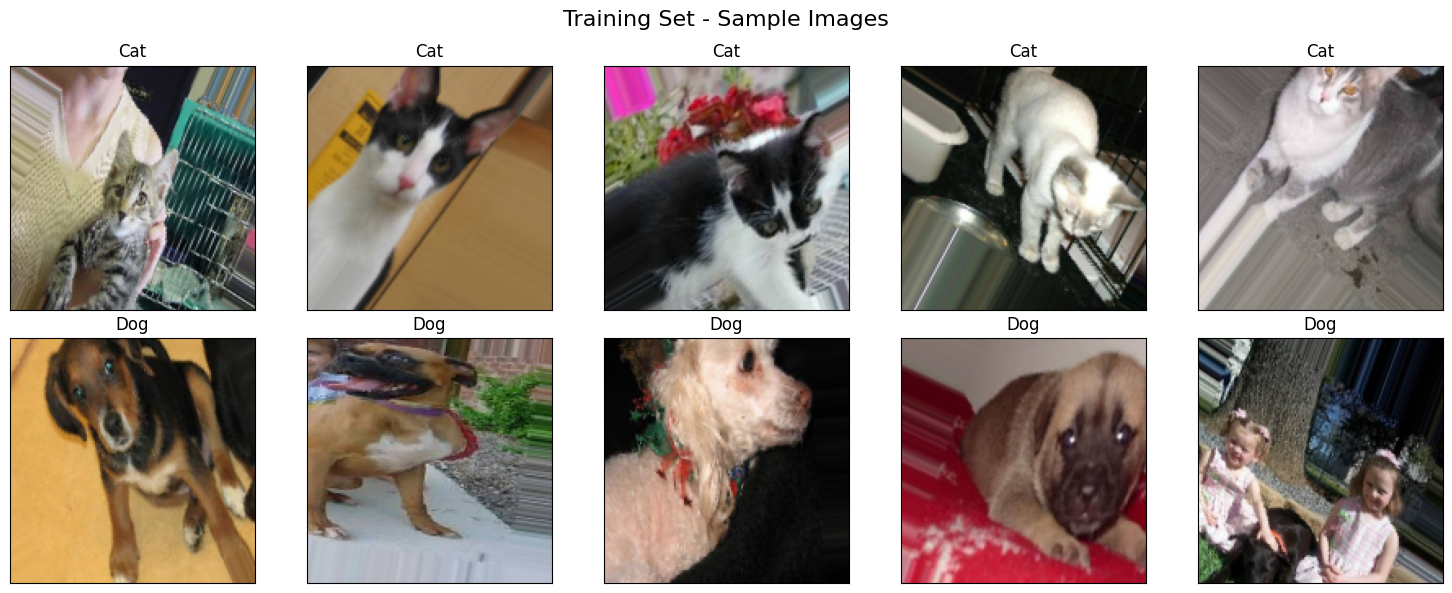


VALIDATION DATA


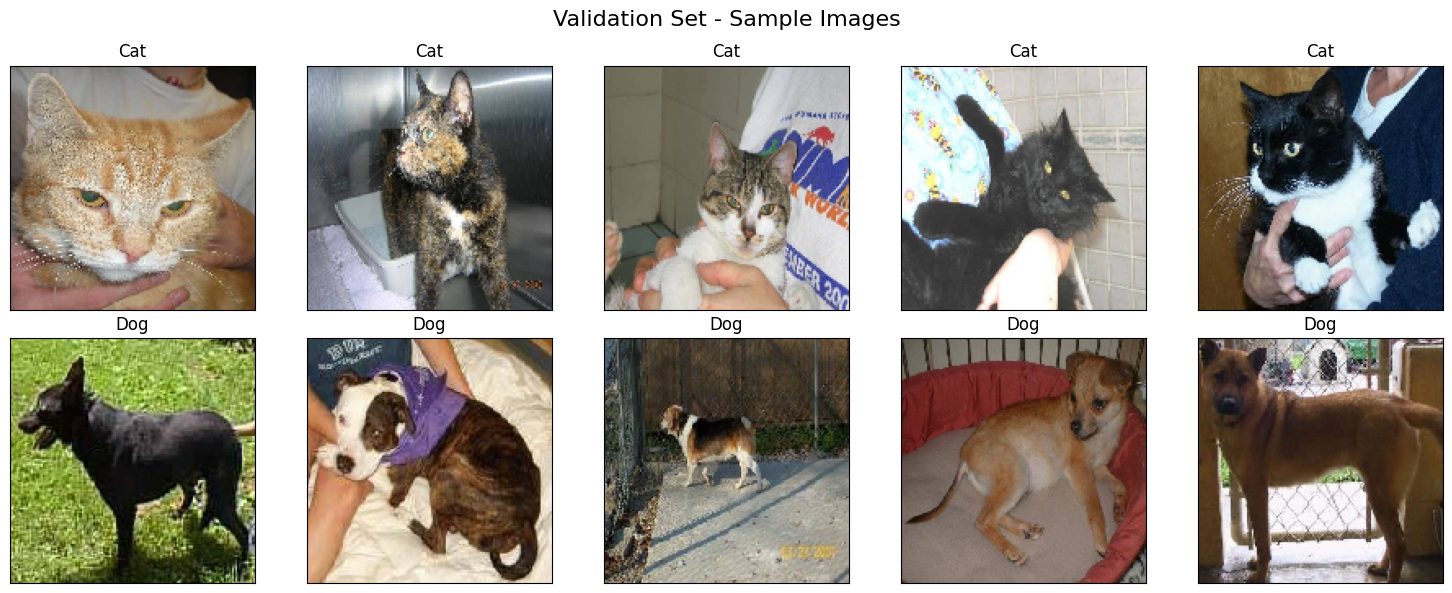

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_samples(generator, dataset_name):
    #Get one batch from generator
    sample_images, sample_labels = next(generator)

    #Get indices for cats (label=0) and dogs (label=1)
    cat_indices = np.where(sample_labels == 0)[0][:5]  # First 5 cats
    dog_indices = np.where(sample_labels == 1)[0][:5]  # First 5 dogs

    #Combine
    selected_indices = np.concatenate([cat_indices, dog_indices])

    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(selected_indices):
        plt.subplot(2, 5, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(sample_images[idx])
        label = 'Cat' if sample_labels[idx] == 0 else 'Dog'
        plt.title(f'{label}')

    plt.suptitle(f'{dataset_name} - Sample Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# Show training samples (5 cats + 5 dogs)
print("TRAINING DATA")
show_samples(train_generator, "Training Set")

# Show validation samples (5 cats + 5 dogs)
print("\nVALIDATION DATA")
show_samples(validation_generator, "Validation Set")

#Reset generators (important! They've been used once)
train_generator.reset()
validation_generator.reset()

## **Model Building**

# **TRIAL 1**

Base version,
changes are as follows:


*   image size = 150,150
*   image color = 3
*   Dense(10, softmax) → Dense(1, sigmoid)
*   More filters: 6,16 → 32,64,128
*   Added one more conv layer (3 instead of 2)





In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='tanh', input_shape=(150, 150, 3)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='tanh'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), activation='tanh'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='sigmoid'))
model.add(layers.Dense(84, activation='sigmoid'))
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 73, 73, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 69, 69, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 34, 34, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 15, 15, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956,073 (15.09 MB)

 Trainable params: 3,956,073 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

**Train the LeNet-5 Model using the training dataset**

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  #for binary classification
              metrics=['accuracy'])

epochNo = 5

history = model.fit(
    train_generator,
    epochs=epochNo,
    validation_data=validation_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 165s 254ms/step - accuracy: 0.5023 - loss: 0.7007 - val_accuracy: 0.5000 - val_loss: 0.6958
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - accuracy: 0.5010 - loss: 0.6958 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.4984 - loss: 0.6950 - val_accuracy: 0.5000 - val_loss: 0.6963
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 252ms/step - accuracy: 0.5042 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6951
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.5000 - loss: 0.6944 - val_accuracy: 0.5000 - val_loss: 0.6932


Plot the trainng set results

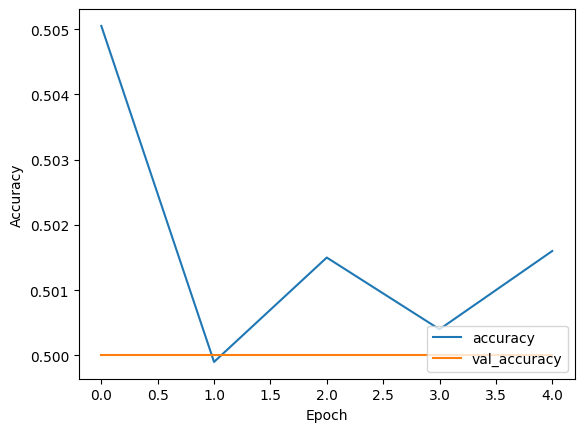

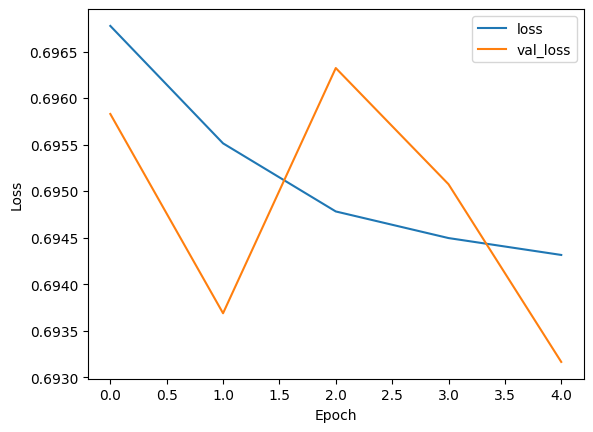

157/157 - 9s - 58ms/step - accuracy: 0.5000 - loss: 0.6932
accuracy = 0.5051, val_accuracy = 0.5000
loss = 0.6943, val_loss = 0.6932


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.margins(0.05, tight=True)
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.margins(0.05, tight=True)
plt.legend(loc='upper right')
plt.show()

# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=2)
print("accuracy = %.4f, val_accuracy = %.4f" %(max(history.history['accuracy']), max(history.history['val_accuracy'])))
print("loss = %.4f, val_loss = %.4f" %(min(history.history['loss']), min(history.history['val_loss'])))

# **TRIAL 2**

EXPERIMENT 2: Fixed version - Using ReLU instead of tanh. Changes are as follows:

*   tanh -> ReLU

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.AveragePooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 73, 73, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 69, 69, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_4             │ (None, 34, 34, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 30, 30, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_5             │ (None, 15, 15, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 84)             │        10,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956,073 (15.09 MB)

 Trainable params: 3,956,073 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochNo = 5

history = model.fit(
    train_generator,
    epochs=epochNo,
    validation_data=validation_generator
)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 230ms/step - accuracy: 0.5116 - loss: 0.6923 - val_accuracy: 0.5466 - val_loss: 0.6849
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.5539 - loss: 0.6830 - val_accuracy: 0.5834 - val_loss: 0.6764
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.5593 - loss: 0.6841 - val_accuracy: 0.5860 - val_loss: 0.6730
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.5832 - loss: 0.6736 - val_accuracy: 0.6470 - val_loss: 0.6276
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.6109 - loss: 0.6546 - val_accuracy: 0.6630 - val_loss: 0.6170


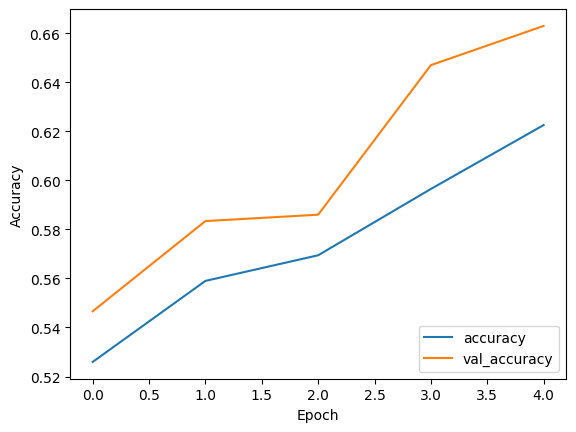

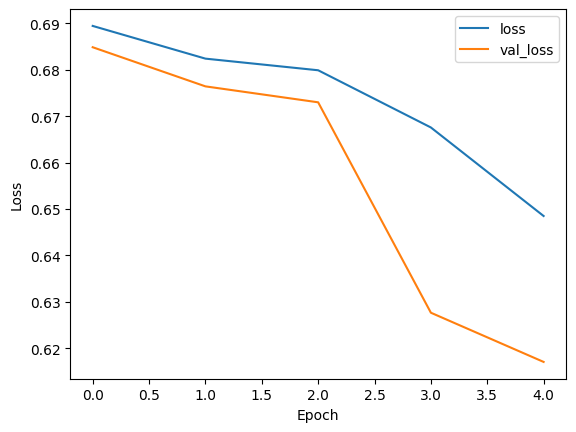

157/157 - 9s - 57ms/step - accuracy: 0.6630 - loss: 0.6170
accuracy = 0.6226, val_accuracy = 0.6630
loss = 0.6485, val_loss = 0.6170


In [ ]:
import matplotlib.pyplot as plt

#Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.margins(0.05, tight=True)
plt.legend(loc='lower right')
plt.show()

#Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.margins(0.05, tight=True)
plt.legend(loc='upper right')
plt.show()

#Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=2)
print("accuracy = %.4f, val_accuracy = %.4f" %(max(history.history['accuracy']), max(history.history['val_accuracy'])))
print("loss = %.4f, val_loss = %.4f" %(min(history.history['loss']), min(history.history['val_loss'])))

# **TRIAL 3**

EXPERIEMNT3: changes are as follows:

*   average pooling -> maxPooling
*   10 epochs

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (5, 5), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 146, 146, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 34, 34, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 28800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,686,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,956,073 (15.09 MB)

 Trainable params: 3,956,073 (15.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochNo = 10

history = model.fit(
    train_generator,
    epochs=epochNo,
    validation_data=validation_generator
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 153s 239ms/step - accuracy: 0.5133 - loss: 0.6928 - val_accuracy: 0.5560 - val_loss: 0.6830
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 236ms/step - accuracy: 0.5521 - loss: 0.6847 - val_accuracy: 0.6264 - val_loss: 0.6630
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 236ms/step - accuracy: 0.6108 - loss: 0.6565 - val_accuracy: 0.6668 - val_loss: 0.6044
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 234ms/step - accuracy: 0.6715 - loss: 0.6071 - val_accuracy: 0.7394 - val_loss: 0.5285
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.7003 - loss: 0.5788 - val_accuracy: 0.7582 - val_loss: 0.5023
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.7191 - loss: 0.5501 - val_accuracy: 0.7858 - val_loss: 0.4529
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 150s 240ms/step - accuracy: 0.7441 - loss: 0.5213 - val_accuracy: 0.7374 - val_loss: 0.5197
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.7481 -

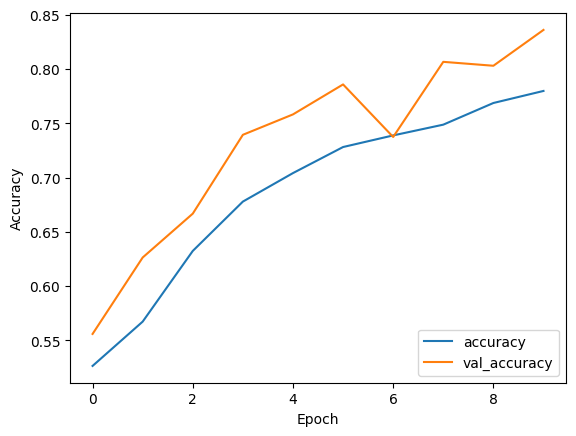

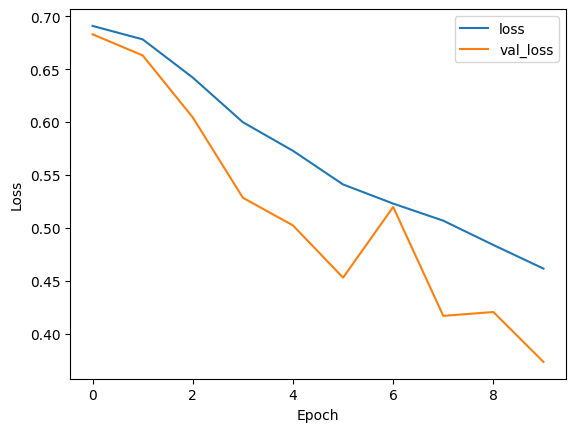

157/157 - 8s - 52ms/step - accuracy: 0.8360 - loss: 0.3733
accuracy = 0.7798, val_accuracy = 0.8360
loss = 0.4615, val_loss = 0.3733


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.margins(0.05, tight=True)
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.margins(0.05, tight=True)
plt.legend(loc='upper right')
plt.show()

# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=2)
print("accuracy = %.4f, val_accuracy = %.4f" %(max(history.history['accuracy']), max(history.history['val_accuracy'])))
print("loss = %.4f, val_loss = %.4f" %(min(history.history['loss']), min(history.history['val_loss'])))

# **TRIAL 4**

EXPERIMENT4: Changes are as follows:

*   (5, 5) -> (3, 3)
*   20 epochs

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        10,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,839,273 (18.46 MB)

 Trainable params: 4,839,273 (18.46 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

epochNo = 20

history = model.fit(
    train_generator,
    epochs=epochNo,
    validation_data=validation_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 167s 256ms/step - accuracy: 0.5438 - loss: 0.6903 - val_accuracy: 0.6520 - val_loss: 0.6272
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.6397 - loss: 0.6331 - val_accuracy: 0.7336 - val_loss: 0.5217
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 154s 246ms/step - accuracy: 0.6977 - loss: 0.5761 - val_accuracy: 0.7698 - val_loss: 0.4919
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 253ms/step - accuracy: 0.7207 - loss: 0.5422 - val_accuracy: 0.7646 - val_loss: 0.4810
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 247ms/step - accuracy: 0.7361 - loss: 0.5238 - val_accuracy: 0.7978 - val_loss: 0.4373
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 251ms/step - accuracy: 0.7633 - loss: 0.4912 - val_accuracy: 0.7546 - val_loss: 0.4915
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 251ms/step - accuracy: 0.7717 - loss: 0.4738 - val_accuracy: 0.8088 - val_loss: 0.4107
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 155s 248ms/step - accuracy: 0.7832 -

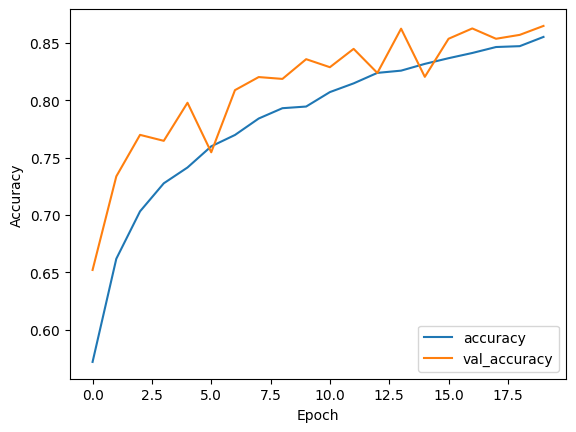

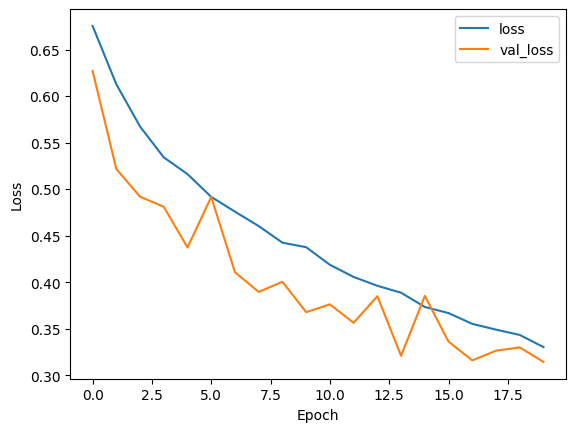

157/157 - 9s - 54ms/step - accuracy: 0.8648 - loss: 0.3142
accuracy = 0.8552, val_accuracy = 0.8648
loss = 0.3302, val_loss = 0.3142


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.margins(0.05, tight=True)
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.margins(0.05, tight=True)
plt.legend(loc='upper right')
plt.show()

# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=2)
print("accuracy = %.4f, val_accuracy = %.4f" %(max(history.history['accuracy']), max(history.history['val_accuracy'])))
print("loss = %.4f, val_loss = %.4f" %(min(history.history['loss']), min(history.history['val_loss'])))

# **TRIAL 5**

EXPERIMENT5: Changes are as follows:

*   new 4th layer
*   dropout
* 20 epochs



# **6**

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(256, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Dense layers
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(84, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

# Compile
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 84)             │        10,836 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,005,097 (7.65 MB)

 Trainable params: 2,005,097 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

# **7**

In [ ]:
epochNo = 20

history = model.fit(
    train_generator,
    epochs=epochNo,
    validation_data=validation_generator
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 234ms/step - accuracy: 0.5115 - loss: 0.6937 - val_accuracy: 0.5538 - val_loss: 0.6841
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.5608 - loss: 0.6845 - val_accuracy: 0.5648 - val_loss: 0.6693
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 229ms/step - accuracy: 0.6122 - loss: 0.6611 - val_accuracy: 0.6632 - val_loss: 0.6276
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 237ms/step - accuracy: 0.6575 - loss: 0.6252 - val_accuracy: 0.6644 - val_loss: 0.6420
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.6733 - loss: 0.6074 - val_accuracy: 0.6930 - val_loss: 0.5732
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 232ms/step - accuracy: 0.6944 - loss: 0.5883 - val_accuracy: 0.7152 - val_loss: 0.5735
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 236ms/step - accuracy: 0.6988 - loss: 0.5744 - val_accuracy: 0.7402 - val_loss: 0.5194
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 235ms/step - accuracy: 0.7235 -

# **8**

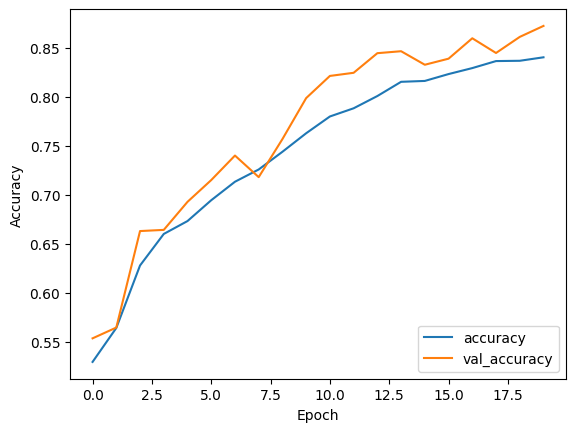

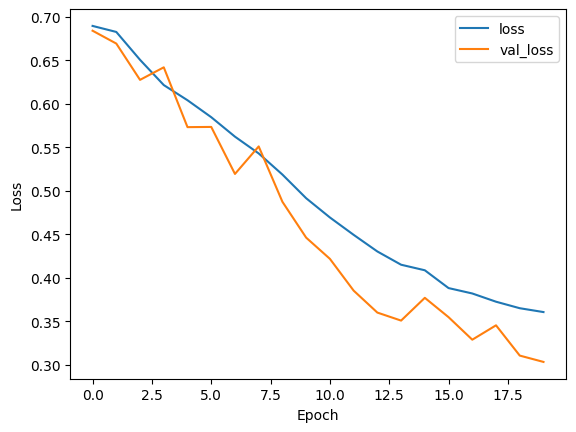

157/157 - 9s - 56ms/step - accuracy: 0.8724 - loss: 0.3033
accuracy = 0.8404, val_accuracy = 0.8724
loss = 0.3606, val_loss = 0.3033


In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.margins(0.05, tight=True)
plt.legend(loc='lower right')
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.margins(0.05, tight=True)
plt.legend(loc='upper right')
plt.show()

# Evaluate on validation data
val_loss, val_acc = model.evaluate(validation_generator, verbose=2)
print("accuracy = %.4f, val_accuracy = %.4f" %(max(history.history['accuracy']), max(history.history['val_accuracy'])))
print("loss = %.4f, val_loss = %.4f" %(min(history.history['loss']), min(history.history['val_loss'])))

# **Since a satisfactory result of 0.84 training accuracy, and 0.87 validation accuracy is obtained, the model will now be used on the testing set**

In [ ]:
# Save the trained model to Google Drive
model.save('/content/drive/MyDrive/AIDM/trained_model_exp4.h5')
print("Model saved!")

Model saved!


## **TEST**



# **9**

Number of JPG images: 500


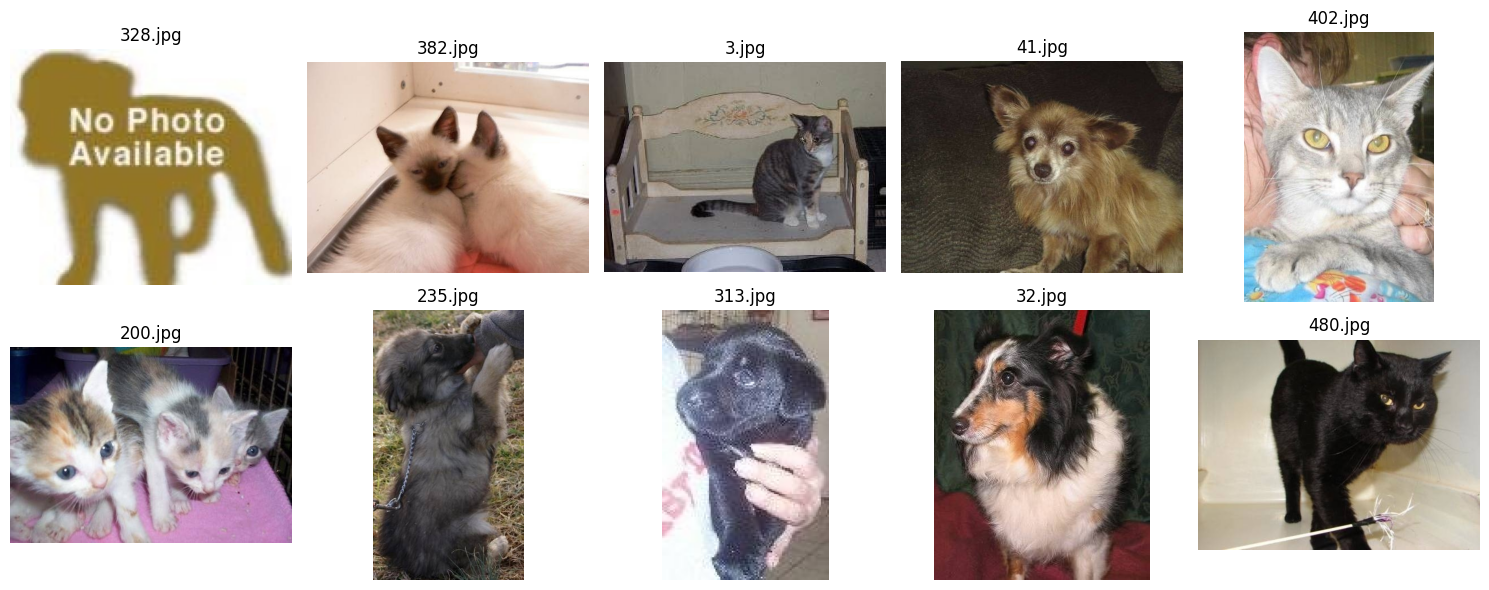

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

test_path = 'datasets/test'

# Get only JPG/JPEG files, sorted numerically
test_files = sorted(
    [f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg'))],
    key=lambda x: int(os.path.splitext(x)[0])
)

print(f"Number of JPG images: {len(test_files)}")

# Select 10 random images to preview
random_files = random.sample(test_files, 10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.ravel()

for i, img_file in enumerate(random_files):
    img_path = os.path.join(test_path, img_file)
    img = Image.open(img_path)

    axes[i].imshow(img)
    axes[i].set_title(img_file)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# **10**

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_images = []
for img_file in test_files:  #sort numerically
    img_path = os.path.join(test_path, img_file)
    img = image.load_img(img_path, target_size=(150, 150))
    img_array = image.img_to_array(img) / 255.0
    test_images.append(img_array)

test_images = np.array(test_images)
print(f"Test images shape: {test_images.shape}")

Test images shape: (500, 150, 150, 3)


# **11**

In [ ]:
import pandas as pd

#Use the trained model to predict
predictions = model.predict(test_images, batch_size=32, verbose=1)

#Create DataFrame with actual filenames (without .jpg)
results_df = pd.DataFrame({
    'id': [os.path.splitext(f)[0] for f in test_files],
    'label': [1 if p > 0.5 else 0 for p in predictions.squeeze()]  # 1=dog, 0=cat
})

#Save to CSV
results_df.to_csv('predictions.csv', index=False)
print("Predictions saved to predictions.csv")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
✅ Predictions saved to predictions.csv
